In [1]:
# No warnings
import warnings
warnings.filterwarnings('ignore') # Filter out warnings

# data analysis and wrangling
import pandas as pd
import numpy as np
import random as rnd

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB # Gaussian Naive Bays
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier #stochastic gradient descent
from sklearn.tree import DecisionTreeClassifier

import xgboost as xgb

# Plot styling
sns.set(style='white', context='notebook', palette='deep')
plt.rcParams[ 'figure.figsize' ] = 9 , 5

/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
data_df = pd.read_csv("train.csv")
songs_df = pd.read_csv("songs.csv")
members_df = pd.read_csv("members.csv")



### get a fraction of the data to work with 

In [3]:
songs = songs_df.sample(frac=1)
members = members_df.sample(frac=1)
data = data_df.sample(frac=0.1)

In [4]:
data.size

4426452

In [5]:
members.size

240821

In [6]:
songs.size

16074240

### Songs info

In [7]:
songs.head()

,song_id,song_length,genre_ids,artist_name,composer,lyricist,language
2174032,virRN7QxC79h8k+oWiVXAgzVQnVZemNi8eDjJR8C670=,229564,940,Forest Sounds Relaxing Spa Music Singing Birds,NaN,NaN,-1.0
2110459,bQGKyfUNA2OX4RXekh5SbDLZQgCzwzNc+ZzHxfOzin0=,237907,2022,HIM,Ville Valo,Ville Valo,52.0
1736236,cUSJAFrrzgA1GVqccGx4fqYpWF//FcAofPezS50bp1s=,628688,1152,Saigenji,Saigenji,NaN,-1.0
1629369,TsgSNIsRqB7G/2k1kUXR6VfKTKYqas3HED8LR0nrIlY=,248303,465,Paul Young,Paul Young| Ian Kewley,Paul Young| Ian Kewley,52.0
884374,3EU+aVUYpaULlgh9iB0icEBEvQoLoh8doaKh8gs/n6M=,222122,465,側田 (Justin Lo),Kit Shen,Chan Wing Him,3.0


### Merge songs and train data along song_id 

In [8]:
song_data = pd.merge(songs, data, on='song_id')
song_data.head()

,song_id,song_length,genre_ids,artist_name,composer,lyricist,language,msno,source_system_tab,source_screen_name,source_type,target
0,5j0Yz/auiigi8DCCqr+MZYevjLjrG1mrhOZ/fnxH1/c=,223104,465,核桃 KurumiQ,張瑀 Yu Chang,張璿 Syuan Chang,3.0,WmZ+pwwo7SJF0CTdQ5R16xukRpckPRXdbNmHqEzfL/0=,discover,Album more,album,1
1,hu7Z3h3bm7/dW//2uD1Jl/EG8IISDcCGCh/MR3oyBkI=,229877,465,豪記大對唱,NaN,NaN,10.0,vo7xWdo6Cq5yR1/pMklQG/pKwPn+acExhCys9b9GHKM=,my library,Local playlist more,local-library,1
2,USSE27utN0n9LbIoIM3L0IL0AR4r189K4XJPQXp/Sx0=,266866,465,張信哲 (Jeff Chang),NaN,NaN,3.0,lUbIvwh7QtCFfU+BWpQdDzW6UUngfTNaTnQG2VqYgOI=,my library,Album more,album,0
3,USSE27utN0n9LbIoIM3L0IL0AR4r189K4XJPQXp/Sx0=,266866,465,張信哲 (Jeff Chang),NaN,NaN,3.0,WOKKemIUSPA7Qd95+TeVXKeE56CJ521RBhxnEiiUtP8=,my library,Local playlist more,local-library,0
4,Bi0n9yHJskwJh9B19/e1OPKzL4Gss9Seaud7P4vmXGw=,249242,465,Train,NaN,NaN,52.0,fF1t/duiX5TAjd2JlR4EpX+e6tx9A8Y+vvD2biaq0hY=,my library,Local playlist more,local-library,1


In [9]:
song_data.source_system_tab.unique()

array(['discover', 'my library', 'search', 'radio', 'listen with',
       'explore', nan, 'null', 'notification', 'settings'], dtype=object)

In [10]:
song_data.source_screen_name.unique()

array(['Album more', 'Local playlist more', 'Artist more', 'Search',
       'Radio', nan, 'Online playlist more', 'Discover Genre',
       'Discover Feature', 'Discover Chart', 'My library',
       'Others profile more', 'Unknown', 'Discover New',
       'My library_Search', 'Explore', 'Search Trends', 'Search Home',
       'Self profile more', 'Concert', 'Payment'], dtype=object)

# Map string values to numbers so that we can make predictions

In [11]:
source_type_mapping = {'local-library': 1, 'online-playlist': 2, 'album': 3, 'song': 4, 'top-hits-for-artist': 5,
                    'radio':6,'local-playlist':7,'song-based-playlist':8,'listen-with':9, 'topic-article-playlist':10}

system_tab_mapping = {'my library': 1, 'search': 2, 'discover': 3, 'song': 4, 'radio': 5,
                    'listen with':6,'explore':7,'notification':8,}

#for scren_name I mad unknown equal to zero like nan values
screen_name_mapping = { 'Unknown': 0,'Album more': 1, 'Artist more': 2, 'Local playlist more': 3, 'Search': 4,
                       'Radio': 5,'Search Trends':6,'Discover Feature':7,'Online playlist more':8,
                       'My library':9, 'Explore':10, 'Others profile more':11,'Discover Chart':12,
                        'Discover New':13,'Discover Genre':14,'Search Home':15, 'My library_Search':16 }



song_data['source_screen_name'] = song_data['source_screen_name'].map(screen_name_mapping)
song_data['source_type'] = song_data['source_type'].map(source_type_mapping)
song_data['source_system_tab'] = song_data['source_system_tab'].map(system_tab_mapping)

# Handle missing values
song_data['source_type'] = song_data['source_type'].fillna(0) 
song_data['source_system_tab'] = song_data['source_system_tab'].fillna(0)
song_data['source_screen_name'] = song_data['source_screen_name'].fillna(0)


song_data.source_type.unique()

array([  3.,   1.,   5.,   7.,   4.,   6.,   2.,   8.,   9.,   0.,  10.])

### Create ranges for song length

In [12]:
song_data.song_length.describe()

count    7.377310e+05
mean     2.451567e+05
std      6.908783e+04
min      1.393000e+03
25%      2.147380e+05
50%      2.418240e+05
75%      2.721950e+05
max      1.085171e+07
Name: song_length, dtype: float64

In [13]:
song_data.loc[ song_data['song_length'] <= 5.266200e+04, 'song_length'] = 0
song_data.loc[(song_data['song_length'] > 5.266200e+04) & (song_data['song_length'] <= 2.182670e+05), 'song_length'] = 1
song_data.loc[(song_data['song_length'] > 2.182670e+05) & (song_data['song_length'] <= 2.439830e+05), 'song_length'] = 2
song_data.loc[(song_data['song_length'] > 2.439830e+05) & (song_data['song_length'] <= 2.769060e+05), 'song_length'] = 3
song_data.loc[ song_data['song_length'] > 2.769060e+05, 'song_length']=4

In [14]:
song_data.head()

,song_id,song_length,genre_ids,artist_name,composer,lyricist,language,msno,source_system_tab,source_screen_name,source_type,target
0,5j0Yz/auiigi8DCCqr+MZYevjLjrG1mrhOZ/fnxH1/c=,2,465,核桃 KurumiQ,張瑀 Yu Chang,張璿 Syuan Chang,3.0,WmZ+pwwo7SJF0CTdQ5R16xukRpckPRXdbNmHqEzfL/0=,3.0,1.0,3.0,1
1,hu7Z3h3bm7/dW//2uD1Jl/EG8IISDcCGCh/MR3oyBkI=,2,465,豪記大對唱,NaN,NaN,10.0,vo7xWdo6Cq5yR1/pMklQG/pKwPn+acExhCys9b9GHKM=,1.0,3.0,1.0,1
2,USSE27utN0n9LbIoIM3L0IL0AR4r189K4XJPQXp/Sx0=,3,465,張信哲 (Jeff Chang),NaN,NaN,3.0,lUbIvwh7QtCFfU+BWpQdDzW6UUngfTNaTnQG2VqYgOI=,1.0,1.0,3.0,0
3,USSE27utN0n9LbIoIM3L0IL0AR4r189K4XJPQXp/Sx0=,3,465,張信哲 (Jeff Chang),NaN,NaN,3.0,WOKKemIUSPA7Qd95+TeVXKeE56CJ521RBhxnEiiUtP8=,1.0,3.0,1.0,0
4,Bi0n9yHJskwJh9B19/e1OPKzL4Gss9Seaud7P4vmXGw=,3,465,Train,NaN,NaN,52.0,fF1t/duiX5TAjd2JlR4EpX+e6tx9A8Y+vvD2biaq0hY=,1.0,3.0,1.0,1


In [15]:
#number of different Genres & artist 
print('# of unique genres:', song_data.genre_ids.nunique())
print('# of unique artist:', song_data.artist_name.nunique())
print('# of unique composer:', song_data.composer.nunique())
print('# of unique lyricist:', song_data.lyricist.nunique())
print('# of unique language:', song_data.language.nunique())
print('# of unique song_id:', song_data.song_id.nunique())



# of unique genres: 409
# of unique artist: 18148
# of unique composer: 31209
# of unique lyricist: 15838
# of unique language: 10
# of unique song_id: 112799


In [16]:
#Drop columns with data that can't be understood
song_data = song_data.drop(['artist_name', 'composer', 'lyricist'], axis=1)
song_data.head()

,song_id,song_length,genre_ids,language,msno,source_system_tab,source_screen_name,source_type,target
0,5j0Yz/auiigi8DCCqr+MZYevjLjrG1mrhOZ/fnxH1/c=,2,465,3.0,WmZ+pwwo7SJF0CTdQ5R16xukRpckPRXdbNmHqEzfL/0=,3.0,1.0,3.0,1
1,hu7Z3h3bm7/dW//2uD1Jl/EG8IISDcCGCh/MR3oyBkI=,2,465,10.0,vo7xWdo6Cq5yR1/pMklQG/pKwPn+acExhCys9b9GHKM=,1.0,3.0,1.0,1
2,USSE27utN0n9LbIoIM3L0IL0AR4r189K4XJPQXp/Sx0=,3,465,3.0,lUbIvwh7QtCFfU+BWpQdDzW6UUngfTNaTnQG2VqYgOI=,1.0,1.0,3.0,0
3,USSE27utN0n9LbIoIM3L0IL0AR4r189K4XJPQXp/Sx0=,3,465,3.0,WOKKemIUSPA7Qd95+TeVXKeE56CJ521RBhxnEiiUtP8=,1.0,3.0,1.0,0
4,Bi0n9yHJskwJh9B19/e1OPKzL4Gss9Seaud7P4vmXGw=,3,465,52.0,fF1t/duiX5TAjd2JlR4EpX+e6tx9A8Y+vvD2biaq0hY=,1.0,3.0,1.0,1


In [17]:
# Special distribution plot 
def plot_distribution( df , var , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , hue=target , aspect=4 , row = row , col = col )
    facet.map( sns.kdeplot , var , shade= True )
    facet.set( xlim=( 0 , df[ var ].max() ) )
    facet.add_legend()
    plt.tight_layout()

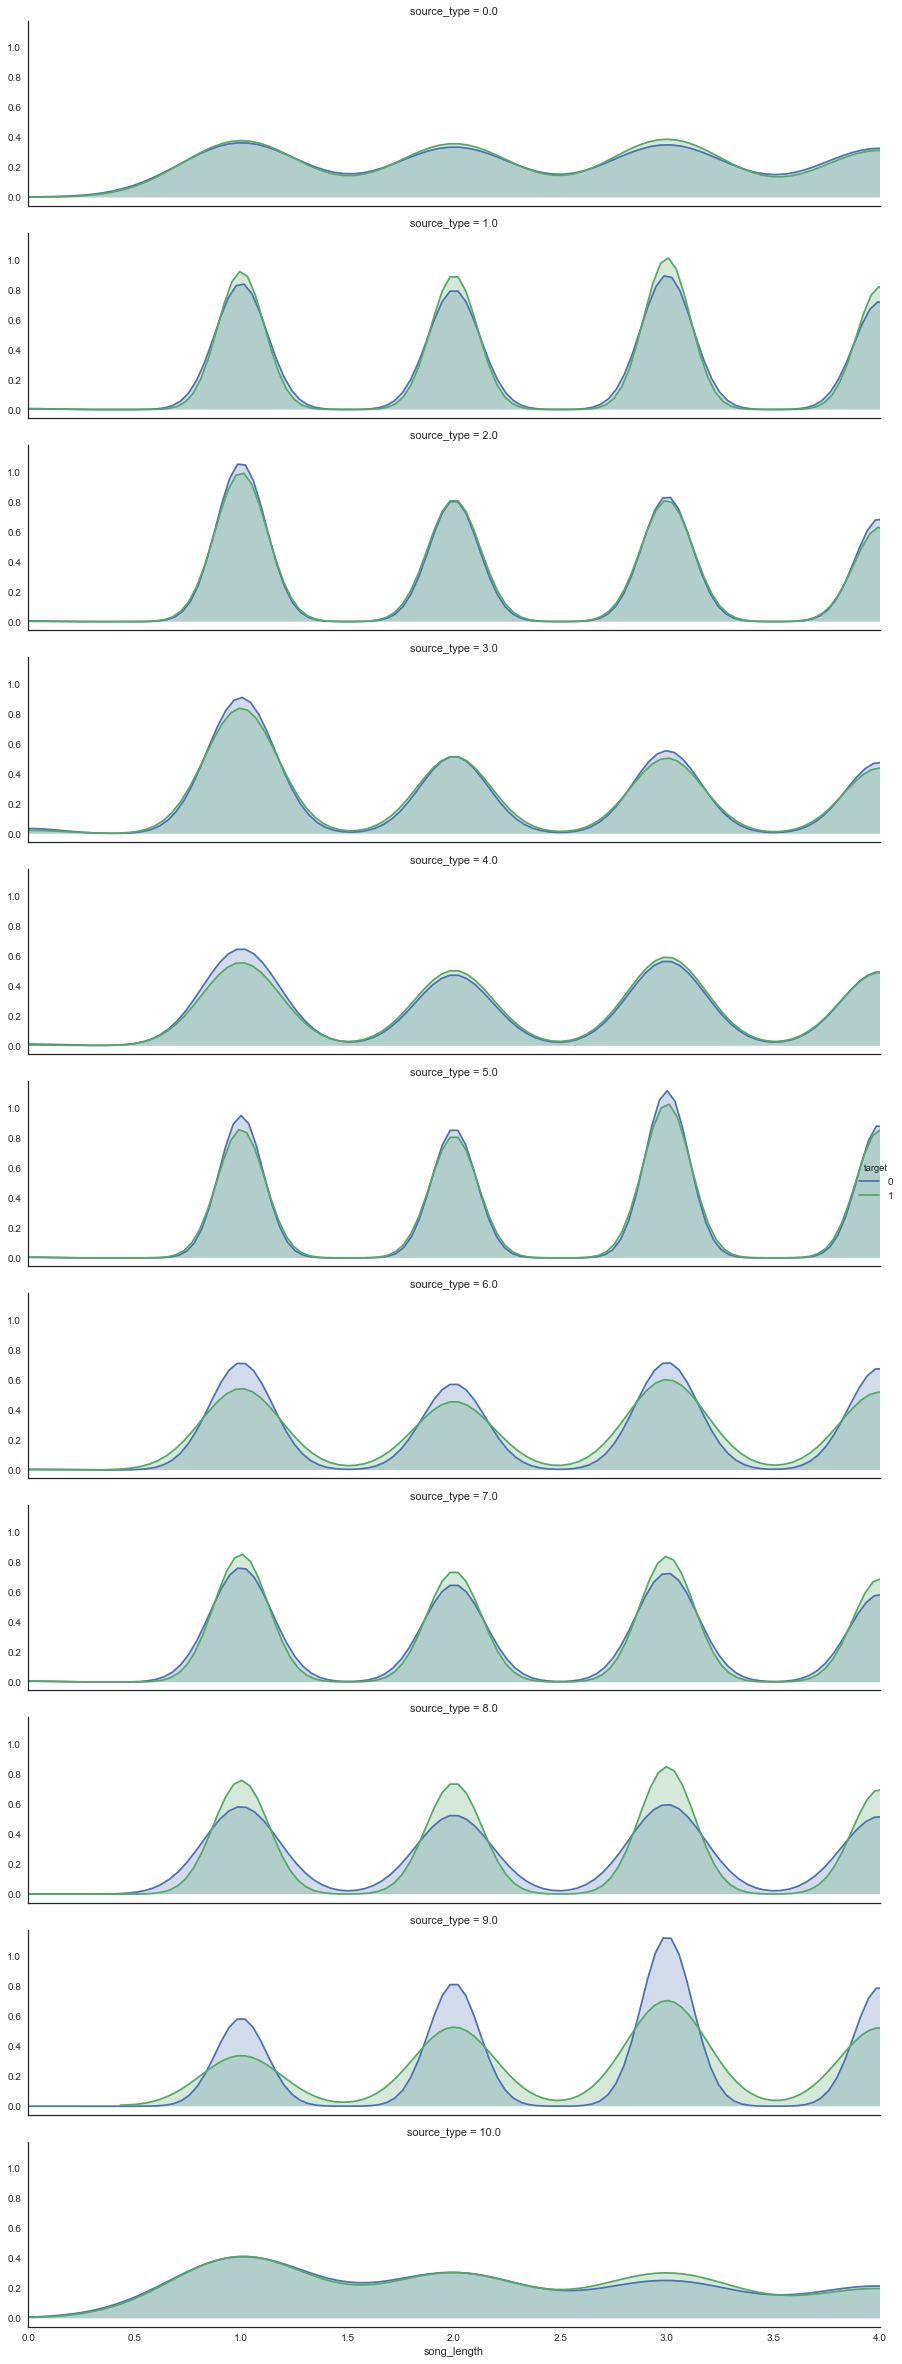

In [18]:
# Plot distributions of songs that got played again 
plot_distribution(song_data, var = 'song_length' , target = 'target' , row = 'source_type' )


# Look at members data set

In [19]:
members.head()

,msno,city,bd,gender,registered_via,registration_init_time,expiration_date
5621,EZ+lxCqwMaO6eiKhznsKzKWPIniyttyAhepvUpOLMqQ=,15,28,male,9,20141223,20161116
22805,CfnKeOlZ30ZSj/VEeCcZPOnDj7A28c7MmfUuvvQ1kpE=,13,21,male,3,20150114,20170906
15382,Zq/Z6NBA5mkIRlhPNzCOT2WeC2GFufW4pKXW9HFOzIY=,1,0,NaN,7,20120117,20170919
10615,34jrP+p4R5WSooAjhjAaE52usP+ken3ytdKs97F1ZuQ=,13,20,male,9,20150405,20170930
12897,CL7l4u0gafL30huqVyV67ksDDNZTV0fcV23sKe2VR1E=,22,38,male,4,20160830,20161105


In [20]:
#regristration & expiration seem irrelivant BUT I SHOULD PROVE IT WITH GRAPH 
members = members.drop(['registration_init_time', 'expiration_date'], axis=1)

In [21]:
#number of different city bd registered_via  
print('# of unique city:', members.city.nunique())
print('# of unique bd:', members.bd.nunique())
print('# of unique registered_via:', members.registered_via.nunique())


# of unique city: 21
# of unique bd: 95
# of unique registered_via: 6


In [22]:
#make new df with only get member ID and Registered_via column 
member_reg = members[['msno','registered_via']].copy()
member_reg.head()

,msno,registered_via
5621,EZ+lxCqwMaO6eiKhznsKzKWPIniyttyAhepvUpOLMqQ=,9
22805,CfnKeOlZ30ZSj/VEeCcZPOnDj7A28c7MmfUuvvQ1kpE=,3
15382,Zq/Z6NBA5mkIRlhPNzCOT2WeC2GFufW4pKXW9HFOzIY=,7
10615,34jrP+p4R5WSooAjhjAaE52usP+ken3ytdKs97F1ZuQ=,9
12897,CL7l4u0gafL30huqVyV67ksDDNZTV0fcV23sKe2VR1E=,4


# Merge all data sets together & analyze 

In [23]:
song_data_member = pd.merge(song_data, member_reg, on='msno').dropna()
print('num of rows:', song_data_member.size)


num of rows: 7259780


# Only need numeric values now that tables are merged

In [24]:
combined_numeric = song_data_member[['song_length','language','source_system_tab','source_screen_name','source_type','registered_via','target']]
combined_numeric.size

5081846

In [25]:
combined_numeric.head()

,song_length,language,source_system_tab,source_screen_name,source_type,registered_via,target
0,2,3.0,3.0,1.0,3.0,3,1
2,2,3.0,1.0,3.0,7.0,3,1
3,3,3.0,1.0,3.0,7.0,3,1
4,2,3.0,1.0,3.0,7.0,3,1
5,3,3.0,1.0,3.0,7.0,3,1


# Correlation

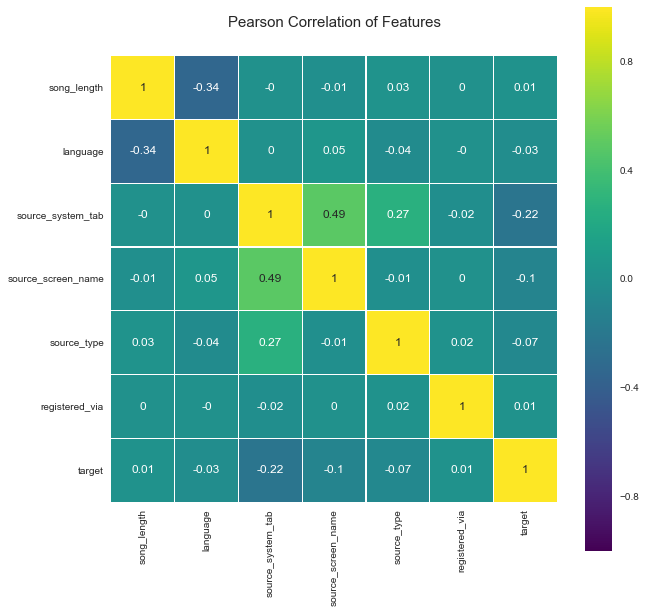

In [26]:
# Check correlation between features 
# (uncorrelated features are generally more powerful predictors)
colormap = plt.cm.viridis
plt.figure(figsize=(10,10))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(combined_numeric.astype(float).corr().round(2)\
            ,linewidths=0.1,vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)

In [27]:
print(combined_numeric.isnull().sum())

song_length           0
language              0
source_system_tab     0
source_screen_name    0
source_type           0
registered_via        0
target                0
dtype: int64


# Start Training 

In [28]:
num_train, num_test = train_test_split(combined_numeric, test_size=0.3)
X_train = num_train.drop("target", axis=1)
Y_train = num_train["target"]
X_test  = num_test.drop("target", axis=1).copy()
Y_test = num_test["target"]
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((508184, 6), (508184,), (217794, 6), (217794,))

In [29]:
# Logistic Regression

logreg = LogisticRegression()
logreg.fit(X_train, Y_train)
Y_pred = logreg.predict(X_test)
acc_log = round(logreg.score(X_train, Y_train) * 100, 2)
acc_log_test = round(logreg.score(X_test, Y_test) * 100, 2)
acc_log_test


60.630000000000003

In [ ]:
# # Support Vector Machines

# svc = SVC()
# svc.fit(X_train, Y_train)
# Y_pred = svc.predict(X_test)
# acc_svc = round(svc.score(X_train, Y_train) * 100, 2)
# acc_svc_test = round(svc.score(X_test, Y_test) * 100, 2)
# acc_svc_test

In [ ]:
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train, Y_train)
Y_pred = knn.predict(X_test)
acc_knn = round(knn.score(X_train, Y_train) * 100, 2)
acc_knn_test = round(knn.score(X_test, Y_test) * 100, 2)
acc_knn_test

In [ ]:
# Perceptron

perceptron = Perceptron()
perceptron.fit(X_train, Y_train)
Y_pred = perceptron.predict(X_test)
acc_perceptron = round(perceptron.score(X_train, Y_train) * 100, 2)
acc_perceptron_test = round(perceptron.score(X_test, Y_test) * 100, 2)
acc_perceptron_test

In [ ]:
# XGBoost

gradboost = xgb.XGBClassifier(n_estimators=1000)
gradboost.fit(X_train, Y_train)
Y_pred = gradboost.predict(X_test)
acc_perceptron = round(gradboost.score(X_train, Y_train) * 100, 2)
acc_perceptron_test = round(gradboost.score(X_test, Y_test) * 100, 2)
acc_perceptron_test

In [53]:
# Random Forest

random_forest = RandomForestClassifier(n_estimators=1000)
random_forest.fit(X_train, Y_train)
Y_pred = random_forest.predict(X_test)
random_forest.score(X_train, Y_train)
acc_random_forest = round(random_forest.score(X_train, Y_train) * 100, 2)

acc_random_forest_test = round(random_forest.score(X_test, Y_test) * 100, 2)
acc_random_forest_test

63.640000000000001

0.980392156863


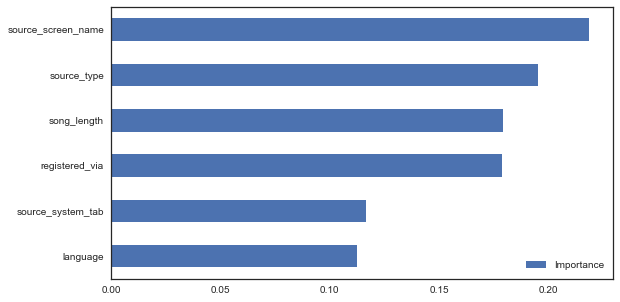

In [46]:
# Look at importnace of features for random forest

def plot_model_var_imp( model , X , y ):
    imp = pd.DataFrame( 
        model.feature_importances_  , 
        columns = [ 'Importance' ] , 
        index = X.columns 
    )
    imp = imp.sort_values( [ 'Importance' ] , ascending = True )
    imp[ : 10 ].plot( kind = 'barh' )
    print (model.score( X , y ))

plot_model_var_imp(random_forest, X_train, Y_train)

In [47]:
print(combined_numeric.isnull().sum())

song_length           0
language              0
source_system_tab     0
source_screen_name    0
source_type           0
registered_via        0
target                0
dtype: int64


In [20]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5901934 entries, 2827858 to 5418493
Data columns (total 6 columns):
msno                  object
song_id               object
source_system_tab     object
source_screen_name    object
source_type           object
target                int64
dtypes: int64(1), object(5)
memory usage: 315.2+ MB


In [21]:
train.count()

msno                  5901934
song_id               5901934
source_system_tab     5887144
source_screen_name    5570060
source_type           5884629
target                5901934
dtype: int64

In [48]:
# Percentage of missing values
def missing(df):
    missing = list()
    for col in df.columns:
        missing.append(sum(pd.isnull(df[col])))
    missing_perc = [100*x / len(df) for x in missing]
    missing_dict = dict()
    i=0
    for col in df.columns:
        missing_dict[col] = missing_perc[i]
        i=i+1
    print(missing_dict)

In [49]:
missing(train)

{'msno': 0.0, 'song_id': 0.0, 'source_system_tab': 0.25059582164083843, 'source_screen_name': 5.6231398046809744, 'source_type': 0.29320897183872269, 'target': 0.0}


In [50]:
import matplotlib.pyplot as plt
%matplotlib inline

In [51]:
train_zeros = train[train["target"]==0].copy()
train_ones = train[train["target"]==1].copy()

train_zeros.head()

,msno,song_id,source_system_tab,source_screen_name,source_type,target
2827858,pMMSfVZEUNV41zp99iRlhdK9RCYbcC+b6I1VdnBTdXU=,MGj5HJB0vl7guEPi5429NGo0C9eiPcnSGveqLP+8OI8=,search,Album more,album,0
3064847,B0AoDUAjURMAjU0Mv7eB3psQxmJsvwY2/l30WR3c0fE=,WsrEXrCcPTWlOostYd8bBBcRZy2vCeB23SRpXK9OhgU=,my library,Local playlist more,local-playlist,0
3236678,1P109u3cfhRDUmEdedYf/ZZuCeyWCKIlWwwazQDTicU=,zgRMEqCvRkgXpPK5QZ9GT2sDq3DHD60gyskMnLAv9NA=,discover,NaN,online-playlist,0
5577068,C/p0MM6vN2GipTdb1XZdXThizVPXm/VKYfgcZ/zsyZg=,OByPlC2K0PEo1H8ZpMdpnJtxo/q7jyjSwbNGuIIGmag=,my library,Local playlist more,local-library,0
6763989,00qmlWC3H/cjf2Ig1li5xIO0VNDRgBX0f9ilouDBEZs=,qcVW/MncLvTIEE6d0EKb3SZNhU5qNsJ09LlRp4VY4so=,my library,Local playlist more,local-playlist,0


In [52]:
train_zeros["target"].value_counts()

0    2929635
Name: target, dtype: int64

In [53]:
train_ones["target"].value_counts()

1    2972299
Name: target, dtype: int64

In [54]:
missing(train_zeros)

{'msno': 0.0, 'song_id': 0.0, 'source_system_tab': 0.23388579123337891, 'source_screen_name': 6.0107487792847918, 'source_type': 0.28136610874733542, 'target': 0.0}


In [55]:
missing(train_ones)

{'msno': 0.0, 'song_id': 0.0, 'source_system_tab': 0.2670659984072935, 'source_screen_name': 5.241094519763994, 'source_type': 0.30488184398675905, 'target': 0.0}


my library      1121124
discover        1018412
radio            296296
search           288290
listen with      114385
explore           77501
notification       3083
null               2967
settings            725
Name: source_system_tab, dtype: int64


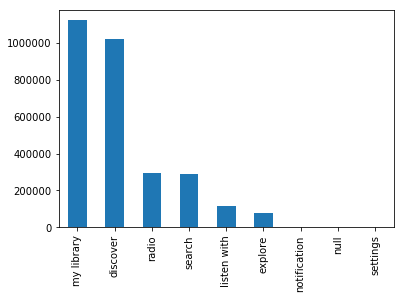

Local playlist more     937657
Online playlist more    605282
Radio                   296946
Album more              204707
Search                  125816
Discover Feature        124394
Artist more             117903
Others profile more     111074
Discover Chart           82880
Discover Genre           42817
Explore                  31872
Unknown                  28568
My library               20823
Discover New              6973
Search Home               6918
Search Trends             6782
My library_Search         2009
Self profile more          101
Concert                     17
Payment                      3
Name: source_screen_name, dtype: int64


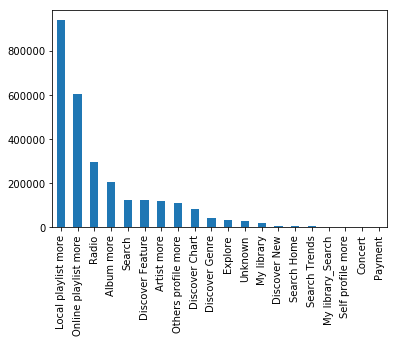

online-playlist           904653
local-library             665527
radio                     301423
local-playlist            295855
album                     231478
top-hits-for-artist       197146
song                      109853
listen-with               105088
song-based-playlist       104467
topic-article-playlist      4531
artist                      1041
my-daily-playlist            330
Name: source_type, dtype: int64


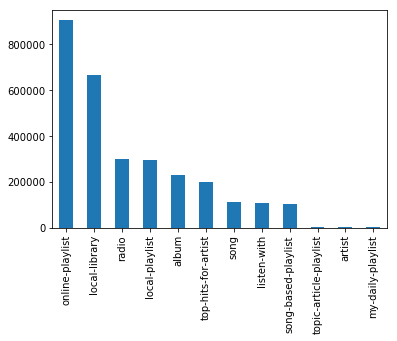

In [58]:
for col in train_zeros.columns[2:-1]:
    train_zeros[col].value_counts().plot(kind='bar')
    print(train_zeros[col].value_counts())
    plt.show()




my library      1826997
discover         724549
search           210261
radio             84999
explore           56788
listen with       55611
null               2287
notification       1847
settings           1022
Name: source_system_tab, dtype: int64


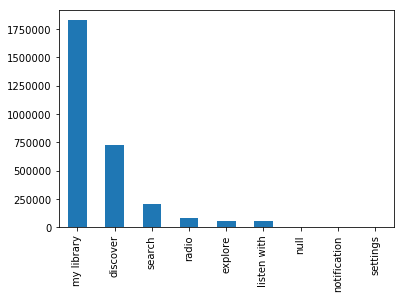

Local playlist more     1645654
Online playlist more     429794
Album more               131341
Search                   112702
Discover Chart            88438
Artist more               84121
Radio                     82577
Discover Feature          70929
Others profile more       50623
My library                39841
Explore                   25948
Discover Genre            22910
Unknown                   14710
Discover New               5787
Search Trends              4099
Search Home                3792
My library_Search          3150
Self profile more            74
Concert                      21
Payment                       7
Name: source_screen_name, dtype: int64


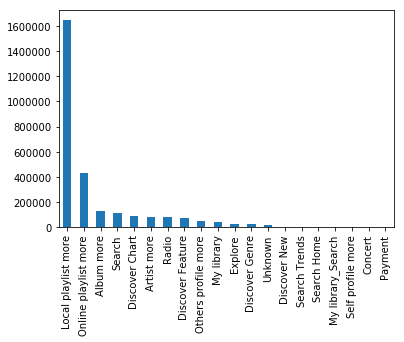

local-library             1143493
online-playlist            668891
local-playlist             568559
album                      150229
top-hits-for-artist        141676
song                        85760
radio                       85058
song-based-playlist         64039
listen-with                 49480
topic-article-playlist       4462
artist                       1387
my-daily-playlist             203
Name: source_type, dtype: int64


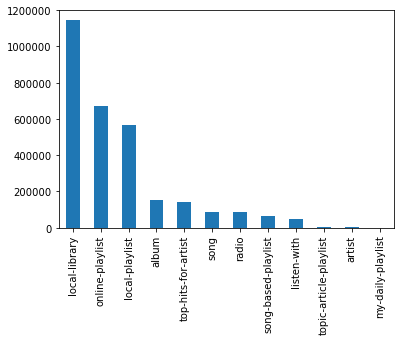

In [60]:
for col in train_ones.columns[2:-1]:
    train_ones[col].value_counts().plot(kind='bar')
    print(train_ones[col].value_counts())
    plt.show()

In [91]:
#Here we calculate the difference in the number of instances in each category between the zeros and ones dataframes.
#If difference is > 0 it means there are more of those instances in the ones dataframe than in the zeros dataframe.
#The number  itself is the normalized amplitude with regards to the number of instances in the ones dataframe. The lager the value, the bigger the relative difference.

for col in train_ones.columns[2:-1]:
    print("-------")
    print(col)
    print("-------")
    for i in train_zeros[col].value_counts().index:
        print(i,":",(train_ones[col].value_counts()[i]-train_zeros[col].value_counts()[i])/train_ones[col].value_counts()[i])

-------
source_system_tab
-------
my library : 0.386356956251
discover : -0.405580574951
radio : -2.48587630443
search : -0.371105435625
listen with : -1.05687723652
explore : -0.364742551243
notification : -0.66919328641
null : -0.297332750328
settings : 0.29060665362
-------
source_screen_name
-------
Local playlist more : 0.430222270295
Online playlist more : -0.408307235559
Radio : -2.59598919796
Album more : -0.558591757334
Search : -0.11635995812
Discover Feature : -0.753781950965
Artist more : -0.401588188443
Others profile more : -1.1941410031
Discover Chart : 0.0628462877948
Discover Genre : -0.86892186818
Explore : -0.228302759365
Unknown : -0.942080217539
My library : 0.477347456138
Discover New : -0.20494211163
Search Home : -0.824367088608
Search Trends : -0.654549890217
My library_Search : 0.362222222222
Self profile more : -0.364864864865
Concert : 0.190476190476
Payment : 0.571428571429
-------
source_type
-------
online-playlist : -0.352466993875
local-library : 0.4179

In [111]:
top3_diff = {"sst_radio": (train_ones["source_system_tab"].value_counts()["radio"]-train_zeros["source_system_tab"].value_counts()["radio"])/train_ones["source_system_tab"].value_counts()["radio"]}
top3_diff["sst_listen with"] = (train_ones["source_system_tab"].value_counts()["listen with"]-train_zeros["source_system_tab"].value_counts()["listen with"])/train_ones["source_system_tab"].value_counts()["listen with"]
top3_diff["sst_notification"] = (train_ones["source_system_tab"].value_counts()["notification"]-train_zeros["source_system_tab"].value_counts()["notification"])/train_ones["source_system_tab"].value_counts()["notification"]

top3_diff["ssn_Radio"] = (train_ones["source_screen_name"].value_counts()["Radio"]-train_zeros["source_screen_name"].value_counts()["Radio"])/train_ones["source_screen_name"].value_counts()["Radio"]
top3_diff["ssn_Others profile more"] = (train_ones["source_screen_name"].value_counts()["Others profile more"]-train_zeros["source_screen_name"].value_counts()["Others profile more"])/train_ones["source_screen_name"].value_counts()["Others profile more"]
top3_diff["ssn_Unknown"] = (train_ones["source_screen_name"].value_counts()["Unknown"]-train_zeros["source_screen_name"].value_counts()["Unknown"])/train_ones["source_screen_name"].value_counts()["Unknown"]

top3_diff["st_radio"] = (train_ones["source_type"].value_counts()["radio"]-train_zeros["source_type"].value_counts()["radio"])/train_ones["source_type"].value_counts()["radio"]
top3_diff["st_listen-with"] = (train_ones["source_type"].value_counts()["listen-with"]-train_zeros["source_type"].value_counts()["listen-with"])/train_ones["source_type"].value_counts()["listen-with"]
top3_diff["st_song-based-playlist"] = (train_ones["source_type"].value_counts()["song-based-playlist"]-train_zeros["source_type"].value_counts()["song-based-playlist"])/train_ones["source_type"].value_counts()["song-based-playlist"]





In [112]:
top3_diff

{'ssn_Others profile more': -1.1941410031013571,
 'ssn_Radio': -2.5959891979606913,
 'ssn_Unknown': -0.9420802175390891,
 'sst_listen with': -1.0568772365179551,
 'sst_notification': -0.66919328641039522,
 'sst_radio': -2.4858763044271108,
 'st_listen-with': -1.1238480194017786,
 'st_radio': -2.5437348632697687,
 'st_song-based-playlist': -0.63130279985633753}

In [116]:
pd.DataFrame.from_dict(top3_diff, orient='index')

,0
sst_radio,-2.485876
sst_listen with,-1.056877
sst_notification,-0.669193
ssn_Radio,-2.595989
ssn_Others profile more,-1.194141
ssn_Unknown,-0.942080
st_radio,-2.543735
st_listen-with,-1.123848
st_song-based-playlist,-0.631303


In [127]:
ssn_radio_ones = train_ones[train_ones["source_screen_name"]!="Radio"].copy()
ssn_radio_zeros = train_zeros[train_zeros["source_screen_name"]!="Radio"].copy()

for col in ssn_radio_ones.columns[2:-1]:
    print("-------")
    print(col)
    print("-------")
    for i in ssn_radio_ones[col].value_counts().index:
        print(i,":",(ssn_radio_ones[col].value_counts()[i]-ssn_radio_zeros[col].value_counts()[i])/ssn_radio_ones[col].value_counts()[i])

-------
source_system_tab
-------
my library : 0.387558556265
discover : -0.40370461897
search : -0.364421919483
explore : -0.358820624956
listen with : -1.05767257673
radio : -0.5413009228
null : -0.291648447748
notification : -0.668110449377
settings : 0.29060665362
-------
source_screen_name
-------
Local playlist more : 0.430222270295
Online playlist more : -0.408307235559
Album more : -0.558591757334
Search : -0.11635995812
Discover Chart : 0.0628462877948
Artist more : -0.401588188443
Discover Feature : -0.753781950965
Others profile more : -1.1941410031
My library : 0.477347456138
Explore : -0.228302759365
Discover Genre : -0.86892186818
Unknown : -0.942080217539
Discover New : -0.20494211163
Search Trends : -0.654549890217
Search Home : -0.824367088608
My library_Search : 0.362222222222
Self profile more : -0.364864864865
Concert : 0.190476190476
Payment : 0.571428571429
-------
source_type
-------
local-library : 0.417997024895
online-playlist : -0.352441664374
local-playlist 

In [128]:
def simple_predictor_v1(df):
    if df["source_screen_name"] == "Radio" or df["source_system_tab"] == "radio" or df["source_type"] == "radio":
        return 0
    elif df["source_screen_name"] == "Others profile more" or df["source_system_tab"] == "listen with" or df["source_type"] == "listen-with":
        return 0
    else:
        return 1

In [146]:
y_pred = list()
j=0
for i in test.index:    
    y_pred.append(simple_predictor_v1(test.loc[i]))


In [147]:
len(y_pred)

1475484

In [148]:
sum(y_pred==test["target"])/len(y_pred)

0.55125233482708047

In [156]:
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn import preprocessing

In [166]:
forest = RFC()
encoder = preprocessing.LabelEncoder()
for col in train.columns[2:5]:
    train[col] = encoder.fit_transform(train[col].fillna('0'))
modl = forest.fit(train[train.columns[2:5]],train["target"])

C:\Users\Thomas\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [173]:
for col in test.columns[2:5]:
    test[col] = encoder.fit_transform(test[col].fillna('0'))
y_pred_rfc = modl.predict(test[test.columns[2:5]])

C:\Users\Thomas\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [174]:
sum(y_pred_rfc==test["target"])/len(y_pred)

0.62636599244722413